In [134]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import string
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
sw = stopwords.words('english')

In [136]:
tweets = pd.read_csv('data/tweet_tweet.csv')
tweets.shape

(9093, 3)

In [137]:
tweets.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [138]:
tweets.rename(
    columns={
        'tweet_text': 'body',
        'emotion_in_tweet_is_directed_at': 'product',
        'is_there_an_emotion_directed_at_a_brand_or_product': 'target'
    },
    inplace=True
)

In [139]:
tweets.head()

,body,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Building a Binary target

In [140]:
binary_df = tweets.copy()

In [141]:
binary_df

,body,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [142]:
binary_df.iloc[3]

body       @sxsw I hope this year's festival isn't as cra...
product                                   iPad or iPhone App
target                                      Negative emotion
Name: 3, dtype: object

In [143]:
binary_df['target'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: target, dtype: int64

In [144]:
binary_df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

Of the 9,000 records, a majority are related to Apple vs Google.

In [145]:
binary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   body     9092 non-null   object
 1   product  3291 non-null   object
 2   target   9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


After exploring the data, we want to fill in the product column nulls based upon the body of the tweet.

In [146]:
# binary_df['product'] = binary_df['product'].fillna(value='poop')

In [147]:
binary_df = binary_df.apply(lambda x: x.astype(str).str.lower())
binary_df['body'] = binary_df['body'].str.replace(r'[^\w\s]+', '')
binary_df['body'] = binary_df['body'].str.replace(r'\d+', '')
binary_df.body = binary_df.body.apply(lambda x: x.split())
binary_df

,body,product,target
0,"[wesley, i, have, a, g, iphone, after, hrs, tw...",iphone,negative emotion
1,"[jessedee, know, about, fludapp, awesome, ipad...",ipad or iphone app,positive emotion
2,"[swonderlin, can, not, wait, for, ipad, also, ...",ipad,positive emotion
3,"[sxsw, i, hope, this, years, festival, isnt, a...",ipad or iphone app,negative emotion
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",google,positive emotion
...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",ipad,positive emotion
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",nan,no emotion toward brand or product
9090,"[googles, zeiger, a, physician, never, reporte...",nan,no emotion toward brand or product
9091,"[some, verizon, iphone, customers, complained,...",nan,no emotion toward brand or product


In [148]:
apple_words = ['apple', 'ipad', 'iphone', 'mac', 'ios']
google_words = ['google', 'android', 'pixel']

def is_apple(x):
    for i in apple_words:
        for j in x:
            if i.lower() in j.lower():
                return 'apple'
            else:
                continue

    
def is_google(x):
    for i in google_words:
        for j in x:
            if i.lower() in j.lower():
                return 'google'
            else:
                continue

 

In [149]:
binary_df['company'] = binary_df.body.apply(is_apple)
binary_df['google'] = binary_df.body.apply(is_google)
binary_df['company'] = binary_df['company'].combine_first(binary_df['google'])
binary_df.drop(columns=['google', 'product'], inplace=True)
binary_df

,body,target,company
0,"[wesley, i, have, a, g, iphone, after, hrs, tw...",negative emotion,apple
1,"[jessedee, know, about, fludapp, awesome, ipad...",positive emotion,apple
2,"[swonderlin, can, not, wait, for, ipad, also, ...",positive emotion,apple
3,"[sxsw, i, hope, this, years, festival, isnt, a...",negative emotion,apple
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",positive emotion,google
...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",positive emotion,apple
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",no emotion toward brand or product,google
9090,"[googles, zeiger, a, physician, never, reporte...",no emotion toward brand or product,google
9091,"[some, verizon, iphone, customers, complained,...",no emotion toward brand or product,apple


# Creating Filters for Company and target

In [150]:
#Company Filters
apple_filter = binary_df['company'] == 'apple'
google_filter = binary_df['company'] == 'google'

#Target Filters
pos_filter = binary_df['target'] == 'positive emotion'
neg_filter = binary_df['target'] == 'negative emotion'
neutral_filter = binary_df['target'] == 'no emotion toward brand or product'

In [196]:
#Creating target filters for each company
apple_pos_df = binary_df[apple_filter & pos_filter]
apple_neg_df = binary_df[apple_filter & neg_filter]
apple_neutral_df = binary_df[apple_filter & neutral_filter]

google_pos_df = binary_df[google_filter & pos_filter]
google_neg_df = binary_df[google_filter & neg_filter]
google_neutral_df = binary_df[google_filter & neutral_filter]

apple_neutral_df

,body,target,company
5,"[teachntech, new, ipad, apps, speechtherapy, c...",no emotion toward brand or product,apple
16,"[holler, gram, ipad, itunes, app, store, httpt...",no emotion toward brand or product,apple
33,"[anyone, sxsw, want, sell, old, ipad]",no emotion toward brand or product,apple
34,"[anyone, sxsw, bought, new, ipad, want, sell, ...",no emotion toward brand or product,apple
37,"[spin, play, new, concept, music, discovery, i...",no emotion toward brand or product,apple
...,...,...,...
9074,"[quotyour, mom, ipad, designing, boomersquot, ...",no emotion toward brand or product,apple
9075,"[quotyour, mom, ipadquot, session, yourmom, sxsw]",no emotion toward brand or product,apple
9076,"[quotyour, mom, ipadquot, session, sxsw, menti...",no emotion toward brand or product,apple
9082,"[apple, guys, screaming, running, line, open, ...",no emotion toward brand or product,apple


In [152]:
apple_pos_df['target'].value_counts()

positive emotion    2142
Name: target, dtype: int64

In [153]:
apple_pos_df

,body,target,company
1,"[jessedee, know, about, fludapp, awesome, ipad...",positive emotion,apple
2,"[swonderlin, can, not, wait, for, ipad, also, ...",positive emotion,apple
8,"[beautifully, smart, and, simple, idea, rt, ma...",positive emotion,apple
9,"[counting, down, the, days, to, sxsw, plus, st...",positive emotion,apple
14,"[great, sxsw, ipad, app, from, madebymany, htt...",positive emotion,apple
...,...,...,...
9072,"[mention, your, iphone, cases, are, rad, and, ...",positive emotion,apple
9077,"[mention, your, pr, guy, just, convinced, me, ...",positive emotion,apple
9079,"[quotpapyrussort, of, like, the, ipadquot, nic...",positive emotion,apple
9085,"[ive, always, used, camera, for, my, iphone, b...",positive emotion,apple


In [154]:
binary_df['body'] = binary_df['body'].apply(lambda x: [item for item in x if item not in sw])

In [155]:
app_corpus_pos = apple_pos_df['body'].to_list()
app_corpus_neutral = apple_neutral_df['body'].to_list()
app_corpus_neg = apple_neg_df['body'].to_list()

goog_corpus_pos = google_pos_df['body'].to_list()
goog_corpus_neutral = google_neutral_df['body'].to_list()
goog_corpus_neg = google_neg_df['body'].to_list()

In [156]:
sentiment_list = [app_corpus_pos, app_corpus_neutral, app_corpus_neg, goog_corpus_pos, goog_corpus_neutral, goog_corpus_neg]

In [157]:
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [178]:
repeat_list = ['sxsw', 'mention', 'apple', 'rt', 'google', 'link', 'sxswi', 'get',
               'iphone', 'ipad', 'android', 'austin', 'downtown', 'win',
              'new', 'app', 'apps', 'line', 'mobile', 'like', 'ipads', 'store', 
               'people', 'one', 'dont', ]

for word in repeat_list:
    sw.append(word)

In [179]:
from wordcloud import WordCloud

In [193]:
def word_count(company_corpus_sent):
    words=[]

    for row in company_corpus_sent:
        for word in row:
            words.append(word)

    wurd = []        

    for word in words:
        if word not in sw:
            wurd.append(word)

    wordz = ' '.join(wurd)
    
    #print(name)
    # Generate a word cloud image
    wordcloud = WordCloud(collocations=False, max_words=15).generate(wordz)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    #lower max_font_size
    wordcloud = WordCloud(max_font_size=100, max_words=15, stopwords=['the'], regexp=r"([a-zA-Z]+(?:’[a-z]+)?)").generate(wordz)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    return pd.Series(wurd).value_counts()[:30]

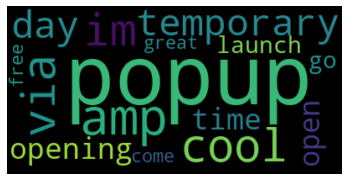

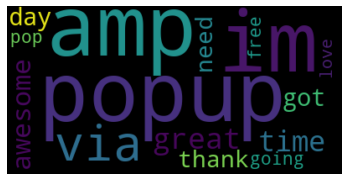

popup        218
amp          119
via          102
cool          98
im            95
temporary     89
opening       87
time          82
launch        79
go            79
great         78
free          77
awesome       73
day           73
love          71
even          67
got           66
open          65
w             58
pop           56
good          54
going         54
first         53
video         53
want          51
shop          49
today         49
need          49
wins          48
check         48
dtype: int64


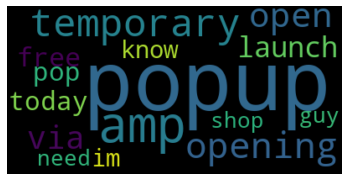

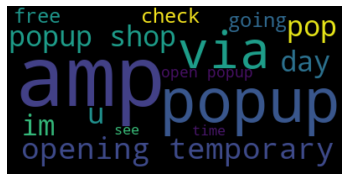

popup         354
amp           276
temporary     167
opening       162
via           128
open          124
launch        118
free          103
pop            96
today          92
shop           87
im             87
know           81
need           78
going          77
congress       72
see            71
th             70
guy            69
anyone         68
time           66
blackberry     65
w              60
check          60
first          60
game           60
tech           59
japan          59
design         57
designing      57
dtype: int64


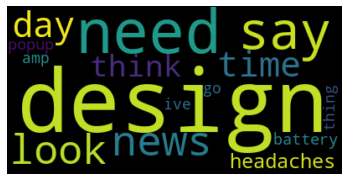

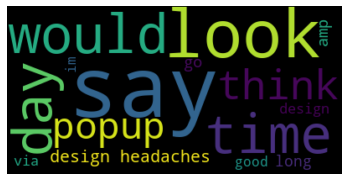

design       28
need         21
news         18
would        17
battery      15
popup        15
headaches    15
says         14
fascist      14
ive          14
amp          14
go           14
company      14
long         14
via          13
time         13
money        13
think        13
day          12
good         12
im           12
fast         12
tapworthy    12
thing        11
see          11
quoti        11
take         11
japan        11
back         11
fail         11
dtype: int64


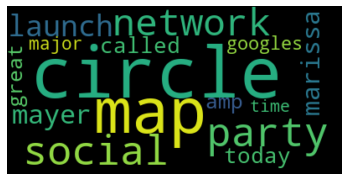

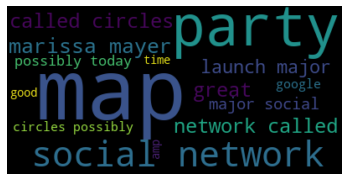

circles     108
maps        101
social      101
party        96
network      83
launch       81
mayer        66
marissa      61
called       60
today        60
amp          57
great        56
googles      55
major        54
time         43
possibly     41
users        38
search       36
day          32
team         32
good         31
around       29
w            29
free         29
see          29
big          29
fun          28
via          28
best         27
traffic      25
dtype: int64


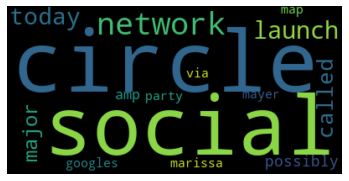

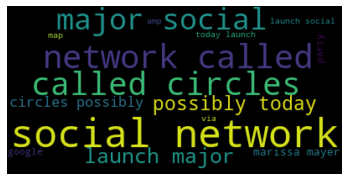

circles       449
social        424
network       338
launch        317
today         295
called        258
major         221
possibly      186
amp           167
party         130
googles       122
mayer         118
via           115
marissa       113
maps           98
search         71
launching      65
location       60
bing           55
big            55
facebook       50
news           49
panel          48
says           45
future         43
time           42
w              42
check          41
quotgoogle     40
going          39
dtype: int64


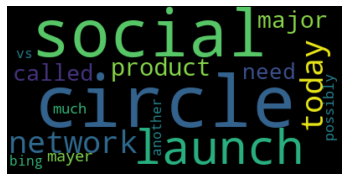

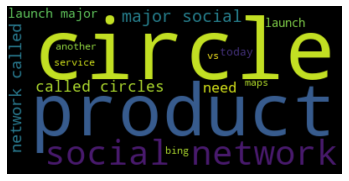

circles       33
social        29
launch        19
today         15
network       13
major         12
called        11
mayer         10
possibly       8
much           8
product        8
another        7
room           7
maps           7
vs             7
tv             7
bing           7
marissa        6
tag            6
quotgoogle     6
better         6
way            6
fail           6
needs          6
users          6
products       5
search         5
time           5
lost           5
data           5
dtype: int64


In [194]:
for corpus in sentiment_list:
    a = word_count(corpus)
    print(a[:30])